In [1]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import numpy as np
import os,random
import cv2
import os
# from tensorflow.keras import backend as K
from tensorflow.compat.v1.keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.90
K.set_session(tf.compat.v1.Session(config=config))

In [3]:
input_path = "data/train/x"
label_path = "data/train/y"
batch_size = 192
img_height, img_width = 128 , 128

In [4]:
def load_data(input_path, channels=3):
    all_files = sorted([f for f in os.listdir(input_path) \
                if os.path.isfile(os.path.join(input_path, f))])
    
    X = np.zeros((1, img_height, img_width, channels), dtype=np.float32)
    for file in all_files:
        image_path = os.path.join(input_path, file)
        if channels==3:
            img = cv2.imread(image_path)
            img = cv2.resize(img, (img_height, img_height))
        else:
            img = cv2.imread(image_path, 0)
            img = cv2.resize(img, (img_height, img_height))
            img = np.expand_dims(img, axis=2)
        img = img/255.
        img = np.expand_dims(img, axis=0).astype(np.float32)
        X = np.concatenate((X, img), axis=0)
    return X

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [5]:
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
# x = UpSampling2D((2, 2))(x)
# x = Conv2D(16, (3, 3), activation='relu')(x)
# x = UpSampling2D((2, 2))(x)
# decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# deconv_1 = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(act_2)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


# def get_model():

#     inputs = Input(shape=(64, 64, 3))

#     conv_1 = Conv2D(1, (3, 3), strides=(1, 1), padding='same')(inputs)
#     act_1 = Activation('relu')(conv_1)

#     conv_2 = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(act_1)
#     act_2 = Activation('relu')(conv_2)

#     deconv_1 = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same')(act_2)
#     act_3 = Activation('relu')(deconv_1)

#     merge_1 = concatenate([act_3, act_1], axis=3)

#     deconv_2 = Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same')(merge_1)
#     act_4 = Activation('relu')(deconv_2)

#     model = Model(inputs=[inputs], outputs=[act_4])

#     model.compile(optimizer='adadelta', loss=dice_coef_loss, metrics=[dice_coef])

#     return model 

In [6]:
class Encoder(Model):
    
    def __init__(self, channel_dim=1):
        super(Encoder, self).__init__(name='encoder')

        self.conv1 = Conv2D(16, (3, 3), padding="same", activation='relu')
        self.conv2 = Conv2D(32, (3, 3), padding="same", activation='relu')
        self.conv3 = Conv2D(64, (3, 3), padding="same", activation='relu')
        
        self.decov1 = Conv2DTranspose(32, (3, 3), strides=(1,1), padding='same', activation='relu')
        self.decov2 = Conv2DTranspose(16, (3, 3), strides=(1,1), padding='same', activation='relu')
        self.decov3 = Conv2DTranspose(3, (3, 3), strides=(2,2), padding='same', activation='relu')
        
        #self.sigmoid = Activation("sigmoid")
        self.bn1 = BatchNormalization(axis=channel_dim)
        self.pool1 = MaxPooling2D(pool_size=(2, 2))
        #self.pool2 = MaxPooling2D(pool_size=(2, 2))
        #self.pool3 = MaxPooling2D(pool_size=(2, 2))
        #self.flatten1 = Flatten()
        #self.dense1 = Dense(512)
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn1(x)
        
        x = self.conv3(x)
        
        x = self.decov1(x)
        x = self.decov2(x)
        x = self.decov3(x)
        
        # x = self.flatten1(x)
        # x = self.dense1(x)
        # x = self.softmax(x)
        return x

In [7]:
model = Encoder()
model.build(input_shape=(None, img_height, img_width, 3))
model.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  448       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4640      
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  18496     
_________________________________________________________________
conv2d_transpose (Conv2DTran multiple                  18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr multiple                  4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr multiple                  435       
_________________________________________________________________
batch_normalization (BatchNo multiple                  256 

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
# plot_model(model, show_shapes=True, show_layer_names=True)

In [9]:
X = load_data(input_path)
Y = load_data(label_path)
X_train = X[:128]
Y_train = Y[:128]
X_test = X[128:]
Y_test = Y[128:]

In [10]:
X_test.shape

(64, 128, 128, 3)

In [12]:
# model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)
model.fit(X_train, Y_train, epochs=1000, batch_size=1024, shuffle=True)

Train on 128 samples
Epoch 1/1000
128/128 [==============================] - 0s 1ms/sample - loss: 0.0026 - accuracy: 0.8614
Epoch 2/1000
128/128 [==============================] - 0s 829us/sample - loss: 0.0028 - accuracy: 0.8618
Epoch 3/1000
128/128 [==============================] - 0s 748us/sample - loss: 0.0029 - accuracy: 0.8506
Epoch 4/1000
128/128 [==============================] - 0s 759us/sample - loss: 0.0027 - accuracy: 0.8799
Epoch 5/1000
128/128 [==============================] - 0s 739us/sample - loss: 0.0027 - accuracy: 0.8417
Epoch 6/1000
128/128 [==============================] - 0s 742us/sample - loss: 0.0028 - accuracy: 0.8395
Epoch 7/1000
128/128 [==============================] - 0s 752us/sample - loss: 0.0026 - accuracy: 0.8608
Epoch 8/1000
128/128 [==============================] - 0s 741us/sample - loss: 0.0026 - accuracy: 0.8761
Epoch 9/1000
128/128 [==============================] - 0s 751us/sample - loss: 0.0027 - accuracy: 0.8506
Epoch 10/1000
128/128 [====

KeyboardInterrupt: 

In [13]:
pred = model(X_test)
pred = pred.numpy()
pred.shape

(64, 128, 128, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

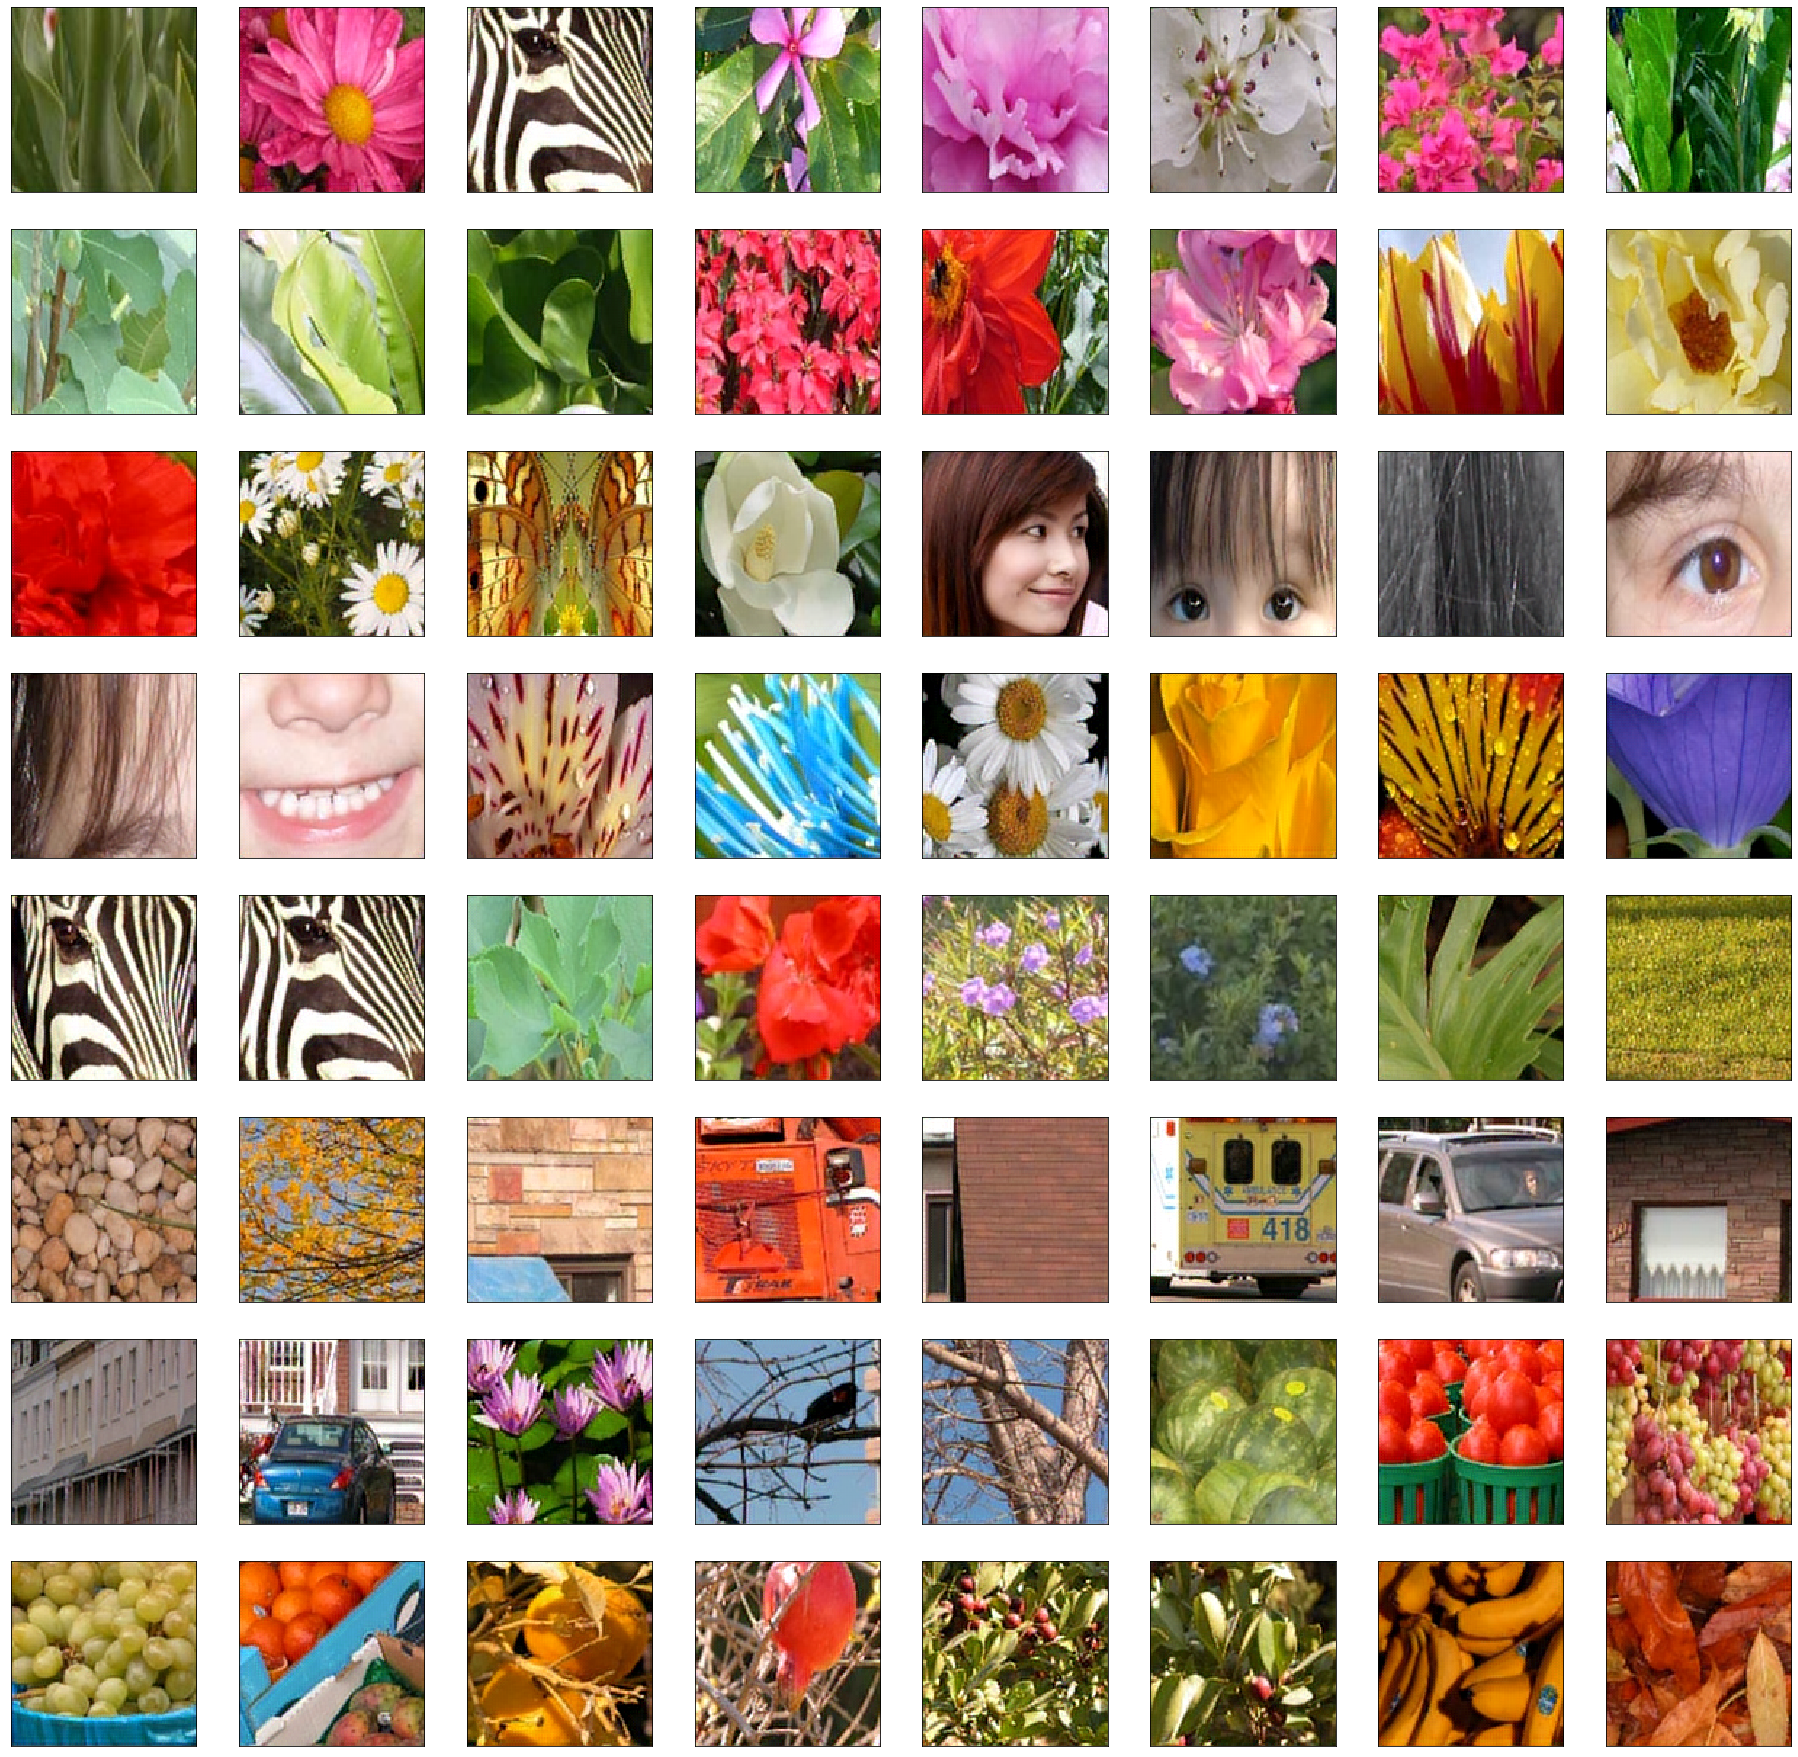

In [22]:
fig=plt.figure(figsize=(32, 32))
columns = 8
rows = 8
for i, im in enumerate(pred,1):
    fig.add_subplot(rows, columns, i)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.imshow(im.astype('float32'))
    plt.xticks([])
    plt.yticks([])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


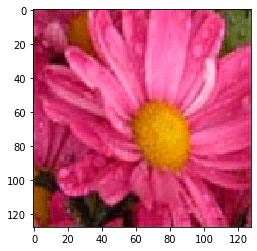

In [26]:
plt.imshow(cv2.cvtColor(pred[1], cv2.COLOR_BGR2RGB))
plt.show()